In [1]:
# You should not need to change this
#
# The next line suppresses output, otherwise you'd see a lot of install notifications.
%%capture
!pip install pandas matplotlib pyproj pymap3d

In [2]:
# You should not need to change this
#
# Import necessary libraries
import pandas as pd  # For data manipulation and reading CSV files
import matplotlib.pyplot as plt  # For plotting images and points
from pyproj import Transformer  # For coordinate system transformations (Geodetic <-> ECEF)
from PIL import Image  # For opening and handling image files
import pymap3d as pm  # For coordinate system transformations (ECEF <-> ENU)
import numpy as np  # For numerical operations, especially with arrays
import cv2  # OpenCV library for computer vision tasks like camera calibration and projection
import os  # For interacting with the operating system, like joining paths
import requests
from io import BytesIO

In [3]:
# YOU MAY want to change this to allow csv / images to be stored and accessed via your google drive
#
# Import the Google Colab drive library to mount Google Drive
#
# If you are running this notebook locally, you dont need this line
# from google.colab import drive

# Mount Google Drive to access files stored there
# This allows the notebook to read data from and write data to your Drive
# drive.mount('/content/drive')

## Setup Local coordinate system

In [4]:
# CHANGE THIS to define the local coordinate system origin (someplace near the camera).  Code I am sharing points this point near Madison Wisconsin.
#
# Define the GPS coordinates (latitude, longitude, altitude) approximately for the camera's origin point
# This point will serve as the reference for the local East-North-Up (ENU) coordinate system
origin_lat = 43.07063697146      # Latitude of the origin point (e.g., camera location)
origin_lon = -89.40685704184578 # Longitude of the origin point
origin_alt = 263 + 204*0.3048     # Altitude of the origin point (calculated example: base + height in feet converted to meters)

# Store the origin GPS coordinates in a tuple
origin_gps = (origin_lat, origin_lon, origin_alt)

## Load the Points CSV

In [5]:
# Define the base directory where the data files are located in Google Drive
# Make sure this path matches the location of your files
# base_url = "/content/drive/MyDrive/homework3" # This variable might not be needed for the CSV path anymore

# Construct the full path to the CSV file containing point correspondences
# Using the raw content URL from GitHub for direct access
path_to_csv = 'https://raw.githubusercontent.com/shrnik/contrails/main/uwisc/east/matches.csv'

# Read the CSV file into a pandas DataFrame
# This file should contain columns for point ID, image coordinates (img_x, img_y),
# and corresponding map coordinates (map_lat, map_lng, map_altitude)
poi_data = pd.read_csv(path_to_csv)

# Display the first few rows of the DataFrame to verify it loaded  correctly
display(poi_data.head())

,id,img_x,img_y,map_lat,map_lng,map_altitude
0,1,915,1582,43.071104,-89.403965,263.678528
1,2,703,1609,43.071366,-89.404300,263.234314
2,3,727,1791,43.071092,-89.405149,264.470459
3,4,2201,1705,43.069481,-89.404959,260.558167
4,5,2215,1540,43.068844,-89.403971,259.164276



# Let's plot some points

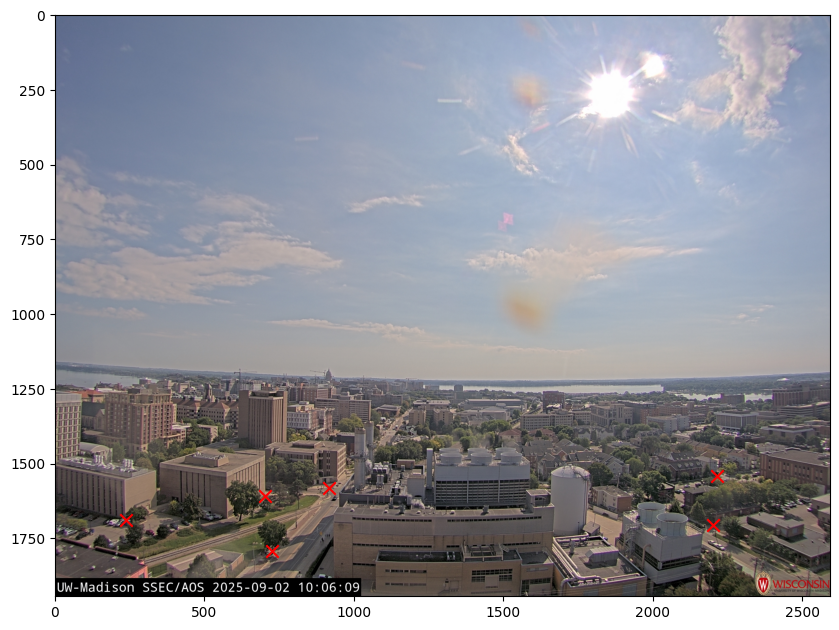

In [6]:
# Let's plot the x,y points we just read in on top of the image and make sure everything makes sense.

# Grab the x,y points we just read in from the CSV above and put it into a numpy array:
poi_xy = poi_data[['img_x', 'img_y']].to_numpy() # Shape: (N, 2)

# Now grab the image:
# If you have a local file, you can put the path here.
# default_img = Image.open("local path...")

# more complicated version to find it from a url:
url = 'https://raw.githubusercontent.com/shrnik/contrails/main/uwisc/east/DEFAULT.jpg'
response = requests.get(url)
default_img = Image.open(BytesIO(response.content))

# Now create the figure:

# Create a figure for plotting
plt.figure(figsize=(10, 8)) # Adjust figure size as needed

# Display the background image
plt.imshow(default_img)

# Plot the original image points (from the input CSV) in red crosses
plt.scatter(poi_xy[:, 0], poi_xy[:, 1], c='red', s=80, marker='x', label='Original POIs (Input Data)')



# Utitlity Functions for Projection and Calibration
## YOU SHOULD NOT NEED TO CHANGE THIS

In [7]:
# Define transformation functions for coordinate systems.
# GPS is (lat, long, alt)
# ECEF is coordinates centered at the center of the earth
# ENU is local east nort up relative to a local origin

def gps_to_ecef(points_gps):
    """
    Converts an array of GPS points (latitude, longitude, altitude) to
    Earth-Centered, Earth-Fixed (ECEF) coordinates.

    Args:
        points_gps (np.ndarray): An Nx3 array where each row is [latitude, longitude, altitude].

    Returns:
        np.ndarray: An Nx3 array where each row is [ECEF_X, ECEF_Y, ECEF_Z].
    """
    # Define the transformation from Geodetic (EPSG:4979) to ECEF (EPSG:4978)
    # always_xy=True ensures the transformer expects (longitude, latitude) order
    transformer_geodetic_to_ecef = Transformer.from_crs(
        "epsg:4979", "epsg:4978", always_xy=True)

    # Perform the transformation
    # Note: pyproj expects longitude, latitude, altitude order for transform
    eX, eY, eZ = transformer_geodetic_to_ecef.transform(
        points_gps[:, 1], points_gps[:, 0], points_gps[:, 2])

    # Stack the results into an Nx3 NumPy array
    ecef_points = np.vstack((eX, eY, eZ)).T
    return ecef_points

def ecef_to_enu(origin_gps, points_ecef):
    """
    Converts ECEF coordinates to local East-North-Up (ENU) coordinates
    relative to a specified ECEF origin point.

    Args:
        origin_gps (np.ndarray): A 1x3 array representing the origin in GPS [latitude, longitude, altitude].
        points_ecef (np.ndarray): An Nx3 array of points in ECEF [X, Y, Z].

    Returns:
        np.ndarray: An Nx3 array of points in ENU [East, North, Up] relative to the origin.
    """
    lat0, lon0, alt0 = origin_gps

    # Use pymap3d to convert the ECEF points to ENU relative to the Geodetic origin
    east, north, up = pm.ecef2enu(points_ecef[:, 0], points_ecef[:, 1], points_ecef[:, 2],
                                  lat0, lon0, alt0)

    # Stack the results into an Nx3 NumPy array and transpose to get the correct shape
    return np.vstack((east, north, up)).T

def estimate_camera_params(poi_enu, poi_xy, frame_size, intrinsics_estimate=None, distortion_estimate=None):
    """
    Estimates camera intrinsic (K) and extrinsic (R, T) parameters using OpenCV's calibrateCamera.

    This function takes known 3D points in ENU coordinates and their corresponding 2D projections
    in the image to estimate the camera's properties.

    Args:
        poi_enu (np.ndarray): Nx3 array of Points of Interest (POIs) in ENU coordinates.
        poi_xy (np.ndarray): Nx2 array of corresponding image coordinates (pixels) for the POIs.
        frame_size (tuple): The (height, width) of the camera image in pixels.
        intrinsics_estimate (np.ndarray, optional): A 3x3 initial guess for the intrinsic matrix (K).
                                                    If None, a default guess based on frame size is used.
        distortion_estimate (np.ndarray, optional): A 5x1 initial guess for distortion coefficients.
                                                     If None, zeros are used.

    Returns:
        tuple: (camera_matrix, dist_coeffs, R, T)
            camera_matrix (np.ndarray): The estimated 3x3 intrinsic matrix (K).
            dist_coeffs (np.ndarray): The estimated 5x1 distortion coefficients.
            R (np.ndarray): The estimated 3x3 rotation matrix (world/ENU to camera).
            T (np.ndarray): The estimated 3x1 translation vector (world/ENU to camera).
    """

    # --- Step 1: Prepare Data for OpenCV ---
    # Ensure arrays are contiguous and have the correct types for OpenCV functions.
    object_points = np.ascontiguousarray(poi_enu, dtype=np.float32) # (N, 3) - 3D points in ENU
    image_points = np.ascontiguousarray(poi_xy, dtype=np.float32)   # (N, 2) - 2D projections

    # --- Step 2: Set Initial Guesses and Parameters for Calibration ---
    # If no initial intrinsic guess is provided, create a basic one.
    # Assumes focal length is large and principal point is image center.
    if intrinsics_estimate is None:
        # A large initial focal length guess can sometimes help convergence.
        estimated_focal_dist = max(frame_size) * 1.5 # Example heuristic
        intrinsics_estimate = np.array([
            [estimated_focal_dist, 0, frame_size[1] / 2], # fx, 0, cx
            [0, estimated_focal_dist, frame_size[0] / 2], # 0, fy, cy
            [0, 0, 1]
        ], dtype=np.float32)

    # If no initial distortion guess is provided, assume no distortion.
    if distortion_estimate is None:
        distortion_estimate = np.zeros((5, 1), dtype=np.float32)

    # Define termination criteria for the iterative optimization process.
    # Use stricter criteria than default for potentially better accuracy.
    criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
        10000,    # Max iterations
        1e-12     # Epsilon (convergence tolerance)
    )

    # Print initial guesses for debugging/information
    print("Initial intrinsics guess:\n", intrinsics_estimate)
    print("Initial distortion guess:\n", distortion_estimate.ravel())

    # Define flags to control the calibration process.
    # CALIB_USE_INTRINSIC_GUESS: Start optimization from the provided intrinsic estimate.
    # CALIB_FIX_PRINCIPAL_POINT: Keep cx, cy fixed. Often reasonable if the center is well-known.
    # CALIB_FIX_ASPECT_RATIO: Keep fx/fy ratio fixed. Common for modern cameras.
    # CALIB_ZERO_TANGENT_DIST: Assume tangential distortion (p1, p2) is zero. Often a safe assumption.
    # CALIB_FIX_K[4,5,6]: Do not estimate higher-order radial distortion coefficients.
    calibrate_flags = (
        cv2.CALIB_USE_INTRINSIC_GUESS |
        cv2.CALIB_FIX_PRINCIPAL_POINT |
        cv2.CALIB_FIX_ASPECT_RATIO |
        cv2.CALIB_ZERO_TANGENT_DIST |
        cv2.CALIB_FIX_K1 | cv2.CALIB_FIX_K2 | cv2.CALIB_FIX_K3 |
        cv2.CALIB_FIX_K4 | cv2.CALIB_FIX_K5 | cv2.CALIB_FIX_K6
        # Note: CALIB_USE_EXTRINSIC_GUESS is removed as we don't provide R, T guesses here.
    )

    # --- Step 3: Perform Camera Calibration ---
    # calibrateCamera requires objectPoints and imagePoints to be lists of arrays (one per view).
    # Since we only have one view, we wrap them in lists.
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        [object_points],      # List containing the Nx3 object points array
        [image_points],       # List containing the Nx2 image points array
        (frame_size[1], frame_size[0]), # frame_size expected as (width, height) by OpenCV
        intrinsics_estimate,  # Initial intrinsic guess
        distortion_estimate,  # Initial distortion guess
        flags=calibrate_flags,
        criteria=criteria
    )

    # --- Step 6: Extract and Format Results ---
    # calibrateCamera returns lists of rvecs and tvecs (one per view). Get the first element.
    t_vector = tvecs[0]
    # Convert the returned rotation vector (Rodrigues) back to a 3x3 rotation matrix.
    r_matrix, _ = cv2.Rodrigues(rvecs[0])

    # Check the return value (ret) which indicates success/quality (reprojection error)
    print(f"Calibration reprojection error: {ret}")

    # Return the estimated parameters and the camera origin in ECEF
    return camera_matrix, dist_coeffs, r_matrix, t_vector

def gps_to_camxy(points_gps, cam_k, cam_r, cam_t, camera_gps_origin, distortion=None):
    """
    Projects GPS points (latitude, longitude, altitude) onto the camera's image plane.

    This function converts GPS coordinates to ECEF, then to ENU relative to the camera origin,
    then transforms ENU points to the camera's coordinate system, and finally projects
    them onto the 2D image plane using camera intrinsics, extrinsics, and distortion coefficients.

    Args:
        points_gps (np.ndarray): An Nx3 array of GPS points [latitude, longitude, altitude].
        cam_k (np.ndarray): 3x3 camera intrinsic matrix (K).
        cam_r (np.ndarray): 3x3 camera rotation matrix (R) transforming ENU to Camera coords.
        cam_t (np.ndarray): 3x1 camera translation vector (T) transforming ENU to Camera coords.
        camera_gps_origin (tuple): The (latitude, longitude, altitude) of the camera origin.
        distortion (np.ndarray, optional): Camera distortion coefficients (k1, k2, p1, p2, k3). Defaults to None (no distortion).

    Returns:
        tuple: (image_x, image_y, cam_distance)
            image_x (np.ndarray): Array of projected x-coordinates in the image (pixels). NaN if point is behind camera.
            image_y (np.ndarray): Array of projected y-coordinates in the image (pixels). NaN if point is behind camera.
            cam_distance (np.ndarray): Array of distances (Z-coordinate) of points in the camera coordinate system.
    """


    # --- Step 1: Convert Input GPS points to ECEF ---
    # Convert all GPS points to ECEF using the dedicated function
    ecef_points = gps_to_ecef(points_gps) # Shape: (N, 3)
    num_points = ecef_points.shape[0]

    # --- Step 2: Convert ECEF points to ENU relative to Camera Origin ---
    # Convert ECEF points to local ENU coordinates using the camera's ECEF position as the origin
    enu_points = ecef_to_enu(camera_gps_origin, ecef_points) # Shape: (N, 3)

    # --- Step 3: Transform ENU points to Camera Coordinate System ---
    # Apply rotation (R) and translation (T) to transform ENU points to the camera's coordinate system.
    # Camera coordinates: X=right, Y=down, Z=forward (into scene)
    # Formula: P_cam = R * P_enu + T
    # We transpose enu_points for matrix multiplication and then transpose back.
    points_cam = (cam_r @ enu_points.T + cam_t).T # Shape: (N, 3)

    # --- Step 4: Handle Points Behind the Camera ---
    # Identify points with Z <= 0, which are behind the camera's image plane.
    behind_camera_mask = points_cam[:, 2] <= 0

    # --- Step 5: Project Points onto Image Plane using OpenCV ---
    # Initialize output arrays with NaN. NaN will remain for points behind the camera.
    image_x = np.full(num_points, np.nan)
    image_y = np.full(num_points, np.nan)
    # The Z coordinate in the camera system represents the distance along the camera's optical axis.
    cam_distance = points_cam[:, 2]

    # Only project points that are in front of the camera (Z > 0)
    valid_points_mask = ~behind_camera_mask
    if np.any(valid_points_mask):
        # Select only the valid ENU points for projection
        enu_points_to_project = enu_points[valid_points_mask]

        # OpenCV's projectPoints function requires:
        # - Object points (in the world/ENU frame for solvePnP/calibrateCamera, but here R and T already map ENU to Cam)
        #   However, projectPoints applies R and T itself. It expects world points, R, T that map world to camera.
        #   Since our R and T map ENU (our 'world' relative to camera origin) to Camera, we provide ENU points.
        # - Rotation vector (rvec): Rodrigues representation of cam_r (world-to-camera rotation)
        # - Translation vector (tvec): cam_t (world-to-camera translation)
        # - Camera matrix (cam_k)
        # - Distortion coefficients (distortion)

        # Convert the 3x3 rotation matrix to a rotation vector (Rodrigues format)
        rvec, _ = cv2.Rodrigues(cam_r)
        # Ensure tvec is float32
        tvec = cam_t.astype(np.float32)

        # If no distortion coefficients are provided, use zeros
        if distortion is None:
            distortion = np.zeros((5, 1), dtype=np.float32)

        # Project the valid 3D points (in ENU) onto the 2D image plane
        image_points, _ = cv2.projectPoints(
            enu_points_to_project.astype(np.float32), # Object points (Nx3)
            rvec,                                      # Rotation vector (3x1)
            tvec,                                      # Translation vector (3x1)
            cam_k,                                     # Camera matrix (3x3)
            distortion                                 # Distortion coefficients (5x1)
        )
        # Reshape the output image points from (N, 1, 2) to (N, 2)
        image_points = image_points.reshape(-1, 2)

        # Assign the calculated image coordinates back to the corresponding original indices
        valid_indices = np.where(valid_points_mask)[0]
        image_x[valid_indices] = image_points[:, 0]
        image_y[valid_indices] = image_points[:, 1]

    # Return the projected x, y coordinates and the camera-frame distances (Z)
    return image_x, image_y, cam_distance

In [8]:
def calculate_fov_from_intrinsics(intrinsics, image_width, image_height):
    """
    Calculate horizontal and vertical field of view (FOV) in degrees
    from the camera intrinsic matrix (K).

    **NOTE:** This calculation assumes a simple pinhole camera model without lens distortion.
             The FOV might differ if significant distortion is present.

    Args:
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix (K).
        image_width (int): Width of the image in pixels.
        image_height (int): Height of the image in pixels.

    Returns:
        tuple: (hfov_deg, vfov_deg)
            hfov_deg (float): Horizontal field of view in degrees.
            vfov_deg (float): Vertical field of view in degrees.
    """
    # Extract focal lengths (fx, fy) and principal point (cx, cy) from the intrinsic matrix
    fx = intrinsics[0, 0]  # Focal length in x-direction (pixels)
    fy = intrinsics[1, 1]  # Focal length in y-direction (pixels)
    cx = intrinsics[0, 2]  # Principal point x-coordinate (pixels)
    cy = intrinsics[1, 2]  # Principal point y-coordinate (pixels)

    # Calculate horizontal FOV
    # Angle from optical center to the left edge + angle from optical center to the right edge
    # tan(angle_left) = cx / fx
    angle_left = np.arctan(cx / fx)
    # tan(angle_right) = (image_width - cx) / fx
    angle_right = np.arctan((image_width - cx) / fx)
    hfov_rad = angle_left + angle_right # Total horizontal FOV in radians

    # Calculate vertical FOV
    # Angle from optical center to the top edge + angle from optical center to the bottom edge
    # tan(angle_top) = cy / fy
    angle_top = np.arctan(cy / fy)
    # tan(angle_bottom) = (image_height - cy) / fy
    angle_bottom = np.arctan((image_height - cy) / fy)
    vfov_rad = angle_top + angle_bottom # Total vertical FOV in radians

    # Convert radians to degrees
    hfov_deg = np.degrees(hfov_rad)
    vfov_deg = np.degrees(vfov_rad)

    # Return FOV in degrees
    return (hfov_deg, vfov_deg)

# Initial Camera Intrinsic Matrix

In [9]:
# --- Initial Camera Intrinsic Matrix (K) Guess ---

# Define an initial guess for the camera's vertical field of view (FOV) in degrees.
# This is often known approximately from camera specifications or can be estimated.
vfov_deg_estimate = 63.59 # Example estimated vertical FOV

# Get image dimensions (height, width)
frame_size = (default_img.height, default_img.width) # OpenCV uses (height, width)

# Calculate an initial guess for the focal length (in pixels) based on the vertical FOV estimate.
# Assumes the principal point is roughly centered (cy = height / 2).
# Formula derived from pinhole model: tan(vfov / 2) = (height / 2) / fy
# Rearranging gives: fy = (height / 2) / tan(vfov / 2)
focal_length_estimate = 0.5 * frame_size[0] / np.tan(0.5 * np.radians(vfov_deg_estimate))

# Create the initial guess for the 3x3 intrinsic matrix K.
# Assumes square pixels (fx = fy) and principal point at the image center.
initial_k = np.array([
    [focal_length_estimate, 0, frame_size[1] / 2], # [fx, 0, cx]
    [0, focal_length_estimate, frame_size[0] / 2], # [0, fy, cy]
    [0, 0, 1]
], dtype=np.float32)

# Prepare Data for Calibration

In [10]:

# Extract 2D image coordinates (poi_xy) from the DataFrame
poi_xy = poi_data[['img_x', 'img_y']].to_numpy() # Shape: (N, 2)

# Extract 3D GPS coordinates (poi_gps) from the DataFrame
poi_gps = poi_data[['map_lat', 'map_lng', 'map_altitude']].to_numpy() # Shape: (N, 3)

# Convert the 3D GPS coordinates to ECEF coordinates
poi_ecef = gps_to_ecef(poi_gps) # Shape: (N, 3)

origin_ecef = gps_to_ecef(np.array([origin_gps])) # Shape: (1, 3)

poi_enu = ecef_to_enu(origin_gps, poi_ecef)

all_poi_ecef = poi_ecef
all_poi_enu = poi_enu
all_poi_xy = poi_xy


# Perform Camera Calibration

In [11]:
# Call the estimation function with the prepared 3D ECEF points, 2D image points,
# camera origin GPS, frame size, and the initial intrinsic matrix guess.
# Distortion is initially set to None, allowing estimate_camera_params to use zeros or estimate it.
k_matrix, dist_coeffs, r_matrix, t_vector = estimate_camera_params(
    poi_enu=all_poi_enu,                 # 3D points in ENU
    poi_xy=all_poi_xy,                 # Corresponding 2D points in image
    frame_size=frame_size,             # Image dimensions (height, width)
    intrinsics_estimate=initial_k,     # Initial guess for K matrix
    distortion_estimate=None           # Initial guess for distortion (use zeros)
)

# --- Output Estimated Parameters ---
# The function estimate_camera_params already prints the initial guesses and reprojection error.
# Now, print the final estimated parameters.
print("\n--- Estimated Camera Parameters ---")
print("Intrinsic Matrix (K):\n", k_matrix)
print("Distortion Coefficients (D):\n", dist_coeffs.ravel()) # Flatten for easier reading
print("Rotation Matrix (R - ENU to Camera):\n", r_matrix)
print("Translation Vector (T - ENU to Camera):\n", t_vector.ravel())

# --- Calculate and Output Estimated FOV ---
# Calculate the horizontal and vertical FOV from the estimated intrinsic matrix
hfov, vfov = calculate_fov_from_intrinsics(k_matrix, frame_size[1], frame_size[0])
print(f"\nEstimated Horizontal FOV: {hfov:.2f} degrees")
print(f"Estimated Vertical FOV: {vfov:.2f} degrees")

Initial intrinsics guess:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion guess:
 [0. 0. 0. 0. 0.]
Calibration reprojection error: 39.4049153591975

--- Estimated Camera Parameters ---
Intrinsic Matrix (K):
 [[1.32758701e+03 0.00000000e+00 1.29600000e+03]
 [0.00000000e+00 1.32758701e+03 9.72000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients (D):
 [0. 0. 0. 0. 0.]
Rotation Matrix (R - ENU to Camera):
 [[-4.14140298e-02 -9.99105263e-01 -8.57622640e-03]
 [ 2.06932573e-01 -1.79476740e-04 -9.78355190e-01]
 [ 9.77478280e-01 -4.22923316e-02  2.06754856e-01]]
Translation Vector (T - ENU to Camera):
 [-6.89869188  1.69874013 32.89800601]

Estimated Horizontal FOV: 88.62 degrees
Estimated Vertical FOV: 72.42 degrees


# Reproject Points and Visualize Results

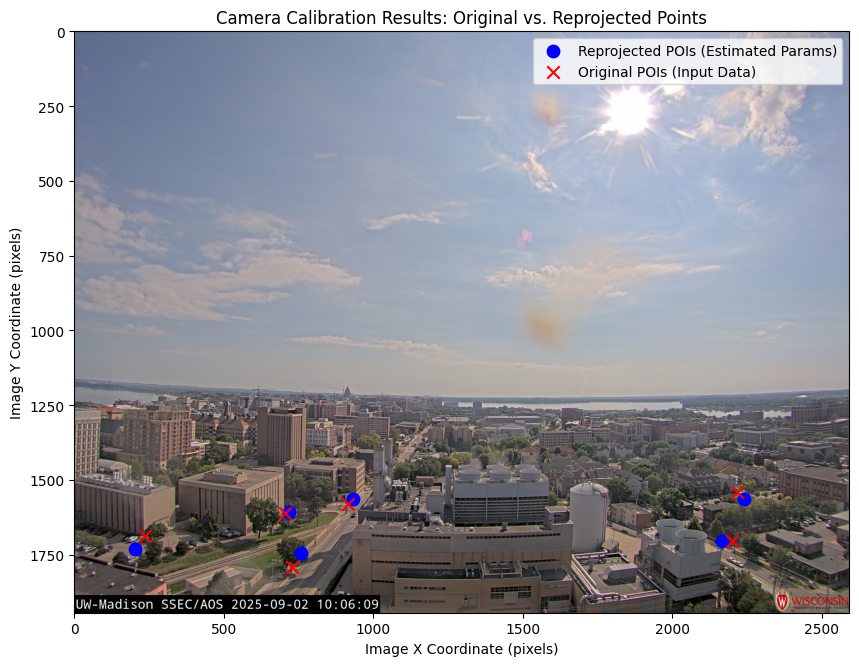

In [12]:

# Use the estimated camera parameters (k_matrix, dist_coeffs, r_matrix, t_vector, cam_ecef_origin)
# to project the original 3D GPS points back onto the 2D image plane.
# This helps visualize the accuracy of the calibration.
image_x_reprojected, image_y_reprojected, cam_distance = gps_to_camxy(
    points_gps=poi_gps,
    cam_k=k_matrix,                    # Estimated K matrix
    cam_r=r_matrix,                    # Estimated R matrix
    cam_t=t_vector,                    # Estimated T vector
    camera_gps_origin=origin_gps,      # Camera origin GPS used in calibration
    distortion=dist_coeffs             # Estimated distortion coefficients
)

# --- Plot the Original and Reprojected Points on the Image ---

# Create a figure for plotting
plt.figure(figsize=(10, 8)) # Adjust figure size as needed

# Display the background image
plt.imshow(default_img)

# Plot the reprojected points (calculated using the estimated parameters) in blue circles
plt.scatter(image_x_reprojected, image_y_reprojected, c='blue', s=80, marker='o', label='Reprojected POIs (Estimated Params)')

# Plot the original image points (from the input CSV) in red crosses
plt.scatter(all_poi_xy[:, 0], all_poi_xy[:, 1], c='red', s=80, marker='x', label='Original POIs (Input Data)')

# Add labels, title, and legend for clarity
plt.title('Camera Calibration Results: Original vs. Reprojected Points')
plt.xlabel('Image X Coordinate (pixels)')
plt.ylabel('Image Y Coordinate (pixels)')
plt.legend() # Show the legend based on the labels provided in scatter plots

# Optionally set limits if needed, e.g., plt.xlim([0, frame_size[1]]), plt.ylim([frame_size[0], 0])
# Set Y-axis limits to match image height, inverted because image origin is top-left
plt.ylim([frame_size[0], 0])
# Set X-axis limits to match image width
plt.xlim([0, frame_size[1]])

# Display the plot
plt.show()

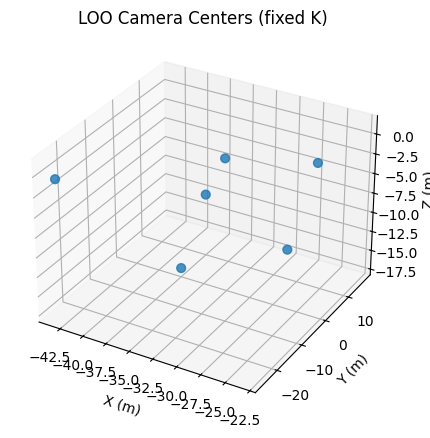

LOO failures: []


In [13]:
# --- Cell A: Leave-One-Out (fixed K) and solvePnP ---

def solve_extrinsics_with_fixed_K(enu_pts, xy_pts, use_ransac=False):
    """
    Solve camera extrinsic parameters using fixed intrinsic matrix K.
    Returns (success, R, T, camera_center).
    """
    objp = enu_pts.astype(np.float32)
    imgp = xy_pts.astype(np.float32)

    try:
        if use_ransac:
            retval, rvec, tvec, inliers = cv2.solvePnPRansac(
                objp, imgp, k_matrix, dist_coeffs,
                flags=cv2.SOLVEPNP_ITERATIVE,
                reprojectionError=8.0,
                iterationsCount=100
            )
        else:
            retval, rvec, tvec = cv2.solvePnP(
                objp, imgp, k_matrix, dist_coeffs,
                flags=cv2.SOLVEPNP_ITERATIVE
            )

        if not retval:
            return False, None, None, np.array([np.nan, np.nan, np.nan])

        R, _ = cv2.Rodrigues(rvec)
        tvec = tvec.reshape(3,1)
        C = (-R.T @ tvec).flatten()
        return True, R, tvec.flatten(), C

    except:
        return False, None, None, np.array([np.nan, np.nan, np.nan])


def leave_one_out_extrinsics(use_ransac=False, save_csv=None, verbose=False):
    """
    Leave-one-out camera extrinsic estimation using fixed K.
    Returns (centers, failures).
    """
    N = all_poi_enu.shape[0]
    centers = []
    failures = []

    for i in range(N):
        mask = np.ones(N, dtype=bool)
        mask[i] = False
        enu_sub = all_poi_enu[mask]
        xy_sub  = all_poi_xy[mask]

        ok, R, T, C = solve_extrinsics_with_fixed_K(enu_sub, xy_sub, use_ransac)
        centers.append(C)

        if not ok:
            failures.append((i, "solvePnP failed"))

    centers = np.array(centers)

    if save_csv:
        import csv
        with open(save_csv, 'w', newline='') as f:
            w = csv.writer(f)
            w.writerow(['drop_idx', 'Cx', 'Cy', 'Cz'])
            for idx, c in enumerate(centers):
                w.writerow([idx, float(c[0]), float(c[1]), float(c[2])])

    return centers, failures


centers_loo, loo_fail = leave_one_out_extrinsics(use_ransac=False, save_csv='loo_centers.csv')

valid = ~np.isnan(centers_loo).any(axis=1)

if valid.any():
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(centers_loo[valid,0], centers_loo[valid,1], centers_loo[valid,2], s=40, alpha=0.8)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('LOO Camera Centers (fixed K)')
    plt.show()
else:
    print("No valid centers.")

print("LOO failures:", loo_fail)


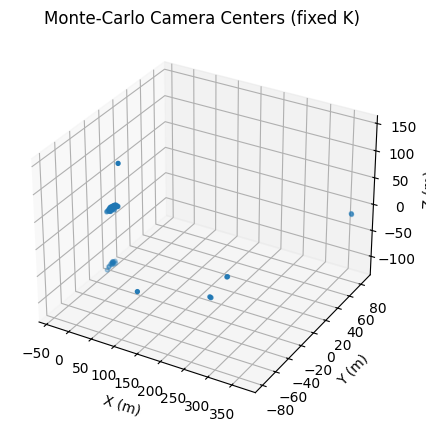

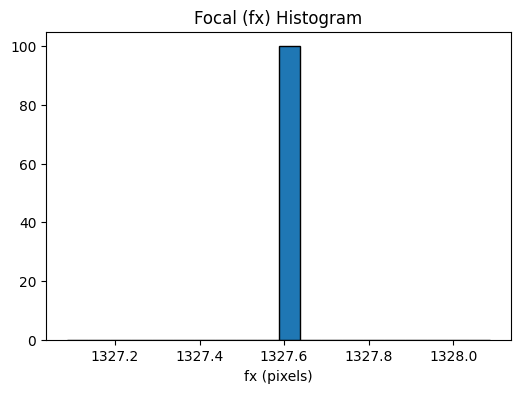

fx stats: mean=1327.59, std=0.00, N=100
Monte-Carlo failures (top 10): []


In [14]:
# --- Cell B: Monte-Carlo noise simulation (fixed K) ---

def monte_carlo_extrinsics(trials=100, sigma_enu=1.0, sigma_px=1.0,
                           use_ransac=False, save_csv='mc_centers_fx.csv',
                           seed=None, verbose=False, reestimate_K=False):
    """
    Monte-Carlo evaluation of extrinsics.
    Add Gaussian noise to ENU and pixel observations.
    Returns (centers, focal_lengths, failures).
    """
    if seed is not None:
        np.random.seed(seed)

    centers = []
    focals = []
    failures = []

    for t in range(trials):
        noisy_enu = all_poi_enu + np.random.normal(0, sigma_enu, all_poi_enu.shape)
        noisy_xy  = all_poi_xy  + np.random.normal(0, sigma_px, all_poi_xy.shape)

        if reestimate_K:
            try:
                K_new, D_new, _, _ = estimate_camera_params(
                    poi_enu=noisy_enu,
                    poi_xy=noisy_xy,
                    frame_size=frame_size,
                    intrinsics_estimate=initial_k,
                    distortion_estimate=None
                )
                K_temp, D_temp = K_new, D_new
            except:
                K_temp, D_temp = k_matrix, dist_coeffs
        else:
            K_temp, D_temp = k_matrix, dist_coeffs

        try:
            objp = noisy_enu.astype(np.float32)
            imgp = noisy_xy.astype(np.float32)
            retval, rvec, tvec = cv2.solvePnP(
                objp, imgp, K_temp, D_temp, flags=cv2.SOLVEPNP_ITERATIVE
            )
            if not retval:
                raise RuntimeError()

            R, _ = cv2.Rodrigues(rvec)
            tvec = tvec.reshape(3,1)
            C = (-R.T @ tvec).flatten()

            centers.append(C)
            focals.append(float(K_temp[0,0]))

        except Exception as e:
            centers.append(np.array([np.nan, np.nan, np.nan]))
            focals.append(np.nan)
            failures.append((t, str(e)))

    import pandas as _pd
    df = _pd.DataFrame(centers, columns=['Cx','Cy','Cz'])
    df["fx"] = focals
    df.to_csv(save_csv, index=False)

    return np.array(centers), np.array(focals), failures


centers_mc, focals_mc, mc_fail = monte_carlo_extrinsics(
    trials=100, sigma_enu=1.0, sigma_px=1.0, seed=0
)

valid = ~np.isnan(centers_mc).any(axis=1)

if valid.any():
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(centers_mc[valid,0], centers_mc[valid,1], centers_mc[valid,2], s=8)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('Monte-Carlo Camera Centers (fixed K)')
    plt.show()

clean_fx = focals_mc[~np.isnan(focals_mc)]

if clean_fx.size > 0:
    plt.figure(figsize=(6,4))
    plt.hist(clean_fx, bins=20, edgecolor='k')
    plt.title("Focal (fx) Histogram")
    plt.xlabel("fx (pixels)")
    plt.show()
    print(f"fx stats: mean={clean_fx.mean():.2f}, std={clean_fx.std():.2f}, N={clean_fx.size}")

print("Monte-Carlo failures (top 10):", mc_fail[:10])
